In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
from results_generator import *
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import backtrader as bt
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf
import warnings

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
np.seterr(all="ignore")
warnings.simplefilter('ignore', pd.errors.PerformanceWarning)

In [3]:
stock_list = pd.read_csv('data/stock_list.csv')['Symbol']
OLS_params = pd.read_csv('results/OLS_params.csv', header=None, index_col=0)[1]
obs = 252 # number of observations used by the model
cash = 100000000
commission = 0.004
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/stock/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])
    stock_dict[stock] = stock_dict[stock][stock_dict[stock].index >= datetime.datetime(2019, 1, 1)].dropna()

In [4]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [5]:
def get_hurst_exponent(time_series, max_lag=20):
    lags = range(2, max_lag)

    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [6]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.obs = obs
        self.n = 0 # number of days
        self.max_n = stock_dict[stock_list[0]].shape[0]
        self.pos = 0 # initial position
        self.leverage = 3
        self.max_buy_portion = 0.9
        
        # stocks selection
        self.req_corr = 0.7
        self.req_adf = 0.01
        self.req_hurst = 0.5
        
        # model settings
        self.model = None
        self.model_list = None
        self.idx_list = None
        self.a, self.b = None, None # index of Sta and Stb
        self.z = norm.ppf(0.99)
        
        # logging the process
        self.date_list = []
        self.Xt_list = []
        self.lb_list = []
        self.ub_list = []

    def signal_generation(self):
        if self.model_list is None or self.n >= self.max_n - 1:
            return 0
        
        if self.model is not None:
            self.Xt = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
    
            if self.pos == 1:
                if self.Xt >= self.EX:
                    return 0
                else:
                    return 1
            elif self.pos == -1:
                if self.Xt <= self.EX:
                    return 0
                else:
                    return -1
        else:
            for i, model in enumerate(self.model_list):
                self.Sta = np.array(self.datas[self.idx_list[i][0]].close.get(size=self.obs))
                self.Stb = np.array(self.datas[self.idx_list[i][1]].close.get(size=self.obs))
                self.Xt = model.alpha * self.Sta[-1] - model.beta * self.Stb[-1]
                self.update_statistics(model)
                if self.Xt > self.EX + self.z * np.sqrt(self.VarX):
                    self.model = model
                    self.a, self.b = self.idx_list[i][0], self.idx_list[i][1]
                    self.corr = self.corr_list[i]
                    self.adf = self.adf_list[i]
                    self.hurst = self.hurst_list[i]
                    self.metrics = self.metrics_list[i]
                    return -1
                elif self.Xt < self.EX - self.z * np.sqrt(self.VarX):
                    self.model = model
                    self.a, self.b = self.idx_list[i][0], self.idx_list[i][1]
                    self.corr = self.corr_list[i]
                    self.adf = self.adf_list[i]
                    self.hurst = self.hurst_list[i]
                    self.metrics = self.metrics_list[i]
                    return 1
            return 0
    
    def update_statistics(self, model):
        self.EX = model.mu
        self.VarX = model.sigma2 / (2 * model.theta)
    
    def renew_model_list(self):
        stock_df = pd.DataFrame()
        for i, stock in enumerate(stock_list):
            stock_df[i] = np.array(self.datas[i].close.get(size=self.obs))
        corr = stock_df.pct_change().corr()
        model_list = []
        idx_list = []
        corr_list = []
        hurst_list = []
        adf_list = []
        metrics_list = []
        for i in range(len(stock_list)):
            for j in range(i):
                if corr[i][j] > self.req_corr: # quick test to choose the appropriate pairs
                    model1 = Ornstein_Uhlenbeck(stock_df[i].values, stock_df[j].values)
                    model2 = Ornstein_Uhlenbeck(stock_df[j].values, stock_df[i].values)
                    swap = 0
                    if model1.l is None and model2.l is None:
                        model = None
                    elif model1.l is None and model2.l is not None:
                        model = model2
                        swap = 1
                    elif model1.l is not None and model2.l is None:
                        model = model1
                    else:
                        if model1.l >= model2.l:
                            model = model1
                        else:
                            model = model2
                            swap = 1
                    
                    hurst = get_hurst_exponent(model.X)
                    adf = adfuller(model.X)
                    if hurst < self.req_hurst and adf[1] < self.req_adf:
                        model_list.append(model)
                        idx_list.append((i, j)) if swap == 0 else idx_list.append((j, i))
                        corr_list.append(corr[i][j])
                        hurst_list.append(hurst)
                        adf_list.append(adf)
                        metrics_list.append(np.dot([hurst, model.mu, model.theta], OLS_params))
        # sort based on the defined metrics 
        if len(model_list) > 0:
            metrics_list = np.array(metrics_list)
            selected_indices = np.argwhere(metrics_list > np.max([0, np.mean(metrics_list)])).flatten()
            sorted_indices = np.argsort(metrics_list[selected_indices])[::-1]
            
            self.model_list = np.array(model_list)[selected_indices][sorted_indices]
            self.idx_list = np.array(idx_list)[selected_indices][sorted_indices]
            self.corr_list = np.array(corr_list)[selected_indices][sorted_indices]
            self.hurst_list = np.array(hurst_list)[selected_indices][sorted_indices]
            self.adf_list = np.array(adf_list)[selected_indices][sorted_indices]
            self.metrics_list = metrics_list[selected_indices][sorted_indices]
        
    def close_positions(self): # to close all existing positions
        self.close(data=self.datas[self.a])
        self.close(data=self.datas[self.b])
    
    def logging(self):
        self.date_list.append(self.data.datetime.date())
        if self.model is not None:
            self.Xt_list.append(self.Xt)
            self.lb_list.append(self.EX - self.z * np.sqrt(self.VarX))
            self.ub_list.append(self.EX + self.z * np.sqrt(self.VarX))
        else:
            self.Xt_list.append(0)
            self.lb_list.append(0)
            self.ub_list.append(0)

        if self.date_list[-1] == self.last_day:
            plt.figure(figsize=(10, 6))
            plt.plot(self.date_list, self.lb_list, label='Lower Bound')
            plt.plot(self.date_list, self.ub_list, label='Upper Bound')
            plt.plot(self.date_list, self.Xt_list, label=r'$X_t$')
            plt.legend()
    
    def start(self):
        self.last_day = self.data.datetime.date(-1)  # Get the last available date
        
    def next(self): 
        self.n += 1
        if self.n >= self.obs:
            if self.model_list is None:
                self.renew_model_list()
            if self.model is not None:
                self.Sta = np.array(self.datas[self.a].close.get(size=self.obs))
                self.Stb = np.array(self.datas[self.b].close.get(size=self.obs))
            
        self.signal = self.signal_generation()
        
        if self.signal != 0 and self.pos == 0:
            print('Number of Pairs: {} | Best Pair\'s Metrics: {:.2f}'.format(len(self.model_list), self.metrics))
    
        if self.signal == 1:
            if self.pos == 0:
                k = self.leverage / (self.Sta[-1] * self.model.alpha + self.model.beta * self.Stb[-1])
                k = np.min([k, 1 / (self.model.alpha * self.Sta[-1])])
                self.buy(data=self.datas[self.a], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.alpha * k)
                self.sell(data=self.datas[self.b], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.beta * k)
                print("{}: Long {} and short {} when Xt = {:.2f}".format(self.data.datetime.date(), stock_list.loc[self.a], stock_list.loc[self.b], self.Xt))
                
        elif self.signal == -1:
            if self.pos == 0:
                k = self.leverage / (self.Sta[-1] * self.model.alpha + self.model.beta * self.Stb[-1])
                k = np.min([k, 1 / (self.model.beta * self.Stb[-1])])
                self.buy(data=self.datas[self.b], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.beta * k)
                self.sell(data=self.datas[self.a], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.alpha * k)
                print("{}: Short {} and long {} when Xt = {:.2f}".format(self.data.datetime.date(), stock_list.loc[self.a], stock_list.loc[self.b], self.Xt))
                
        else: # self.signal == 0
            if self.pos != 0:
                self.close_positions()
                self.model = None
                print("{}: Close pair when Xt = {:.2f}".format(self.data.datetime.date(), self.Xt))
                
        self.pos = self.signal
        
        if self.n >= self.obs:
            self.logging()
            
            if self.pos == 0:
                self.model_list = None

In [7]:
# backtest settings
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(cash)
cerebro.broker.setcommission(commission=commission)

Number of Pairs: 6 | Best Pair's Metrics: 0.01
2020-01-30: Short CCI and long AMT when Xt = 0.34
2020-03-19: Close pair when Xt = 0.27
Number of Pairs: 83 | Best Pair's Metrics: 0.01
2020-03-20: Long ROK and short STT when Xt = 0.23
2020-03-25: Close pair when Xt = 0.36
Number of Pairs: 130 | Best Pair's Metrics: 0.01
2020-03-26: Short ROK and long STT when Xt = 0.39
2020-03-31: Close pair when Xt = 0.30
Number of Pairs: 132 | Best Pair's Metrics: 0.01
2020-04-01: Long EVRG and short LMT when Xt = 0.02
2020-04-08: Close pair when Xt = 0.12
Number of Pairs: 219 | Best Pair's Metrics: 0.01
2020-04-09: Short SWK and long C when Xt = 0.24
2022-06-01: Close pair when Xt = 0.14
Number of Pairs: 9 | Best Pair's Metrics: 0.01
2022-06-09: Long AEE and short SO when Xt = 0.26
2022-11-18: Close pair when Xt = 0.30
Number of Pairs: 26 | Best Pair's Metrics: 0.01
2022-11-21: Long FANG and short SLB when Xt = 0.28
2023-12-28: Close pair when Xt = 0.34


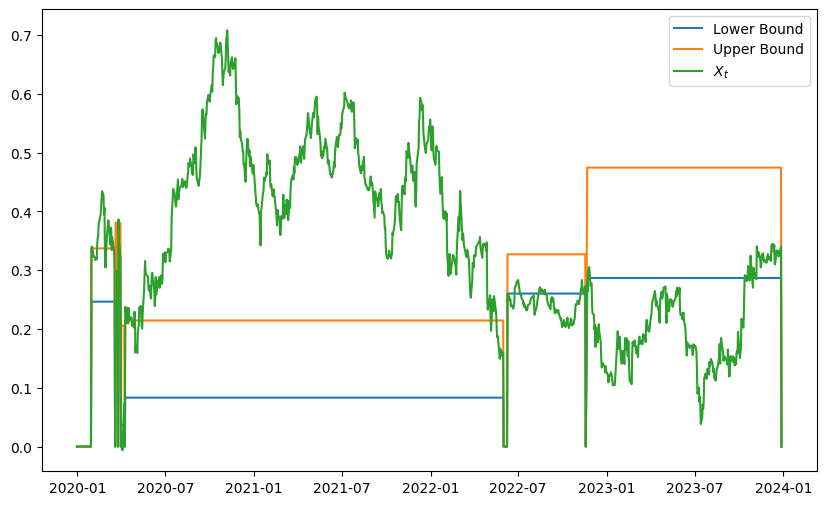

In [8]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

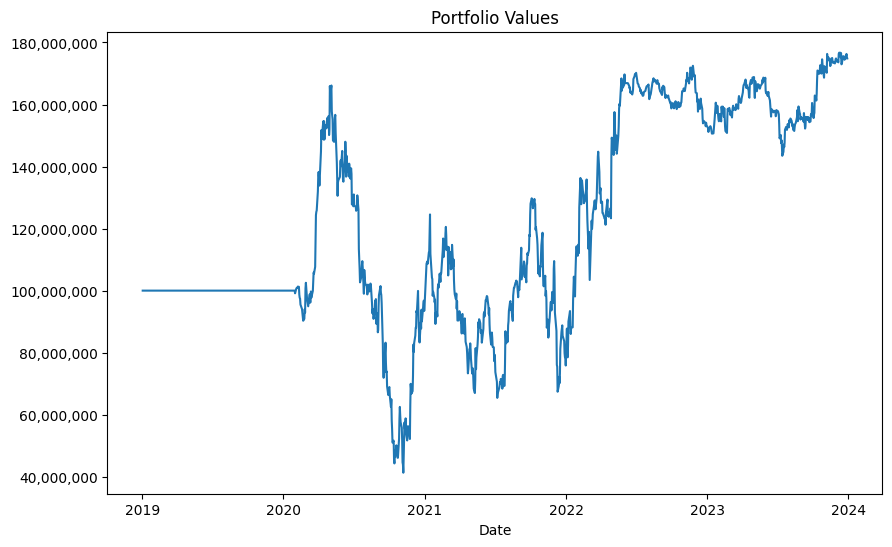

In [9]:
plot_portfolio_values(cash, returns)

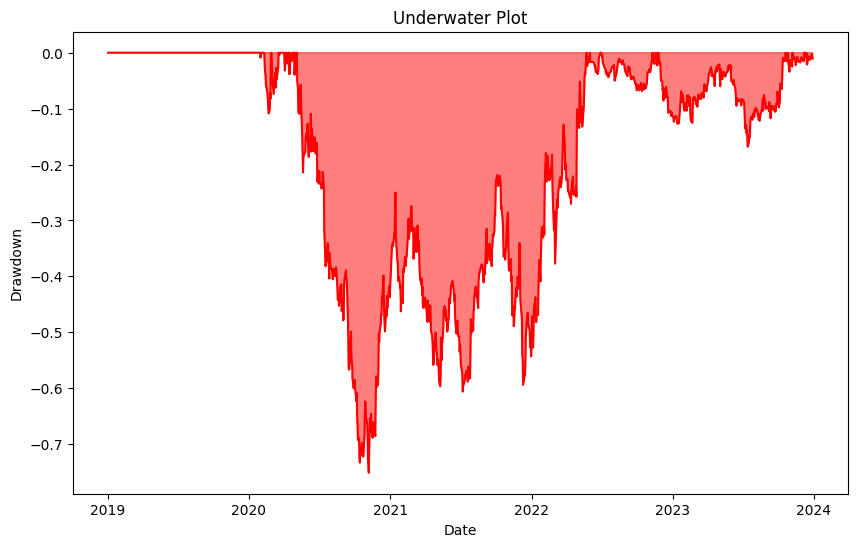

In [10]:
plot_underwater(returns)

                    In-sample Out-of-sample        All
Annual return            0.0%         15.0%      11.8%
Cumulative returns       0.0%         74.9%      74.9%
Annual volatility        0.0%         58.7%      52.5%
Sharpe ratio              NaN      0.522965   0.467657
Calmar ratio              NaN      0.199948   0.157622
Stability                 0.0       0.43592    0.40739
Max drawdown             0.0%        -75.1%     -75.1%
Omega ratio               NaN        1.1127     1.1127
Sortino ratio             NaN      0.834402   0.746163
Skew                      NaN      1.574578   1.782345
Kurtosis                  NaN     15.353731  19.993606
Tail ratio                NaN      1.093766    1.01258
Daily value at risk      0.0%         -7.3%      -6.5%


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will b

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,75.14,2020-05-04,2020-11-06,2022-05-24,537
1,16.82,2022-11-25,2023-07-14,2023-10-20,236
2,10.87,2020-02-07,2020-02-21,2020-02-28,16
3,7.39,2020-02-28,2020-03-05,2020-03-18,14
4,6.87,2022-07-01,2022-10-14,2022-11-10,95


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1305: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1321: UserWarning: set_tic

Stress Events,mean,min,max
New Normal,0.10%,-13.89%,39.23%


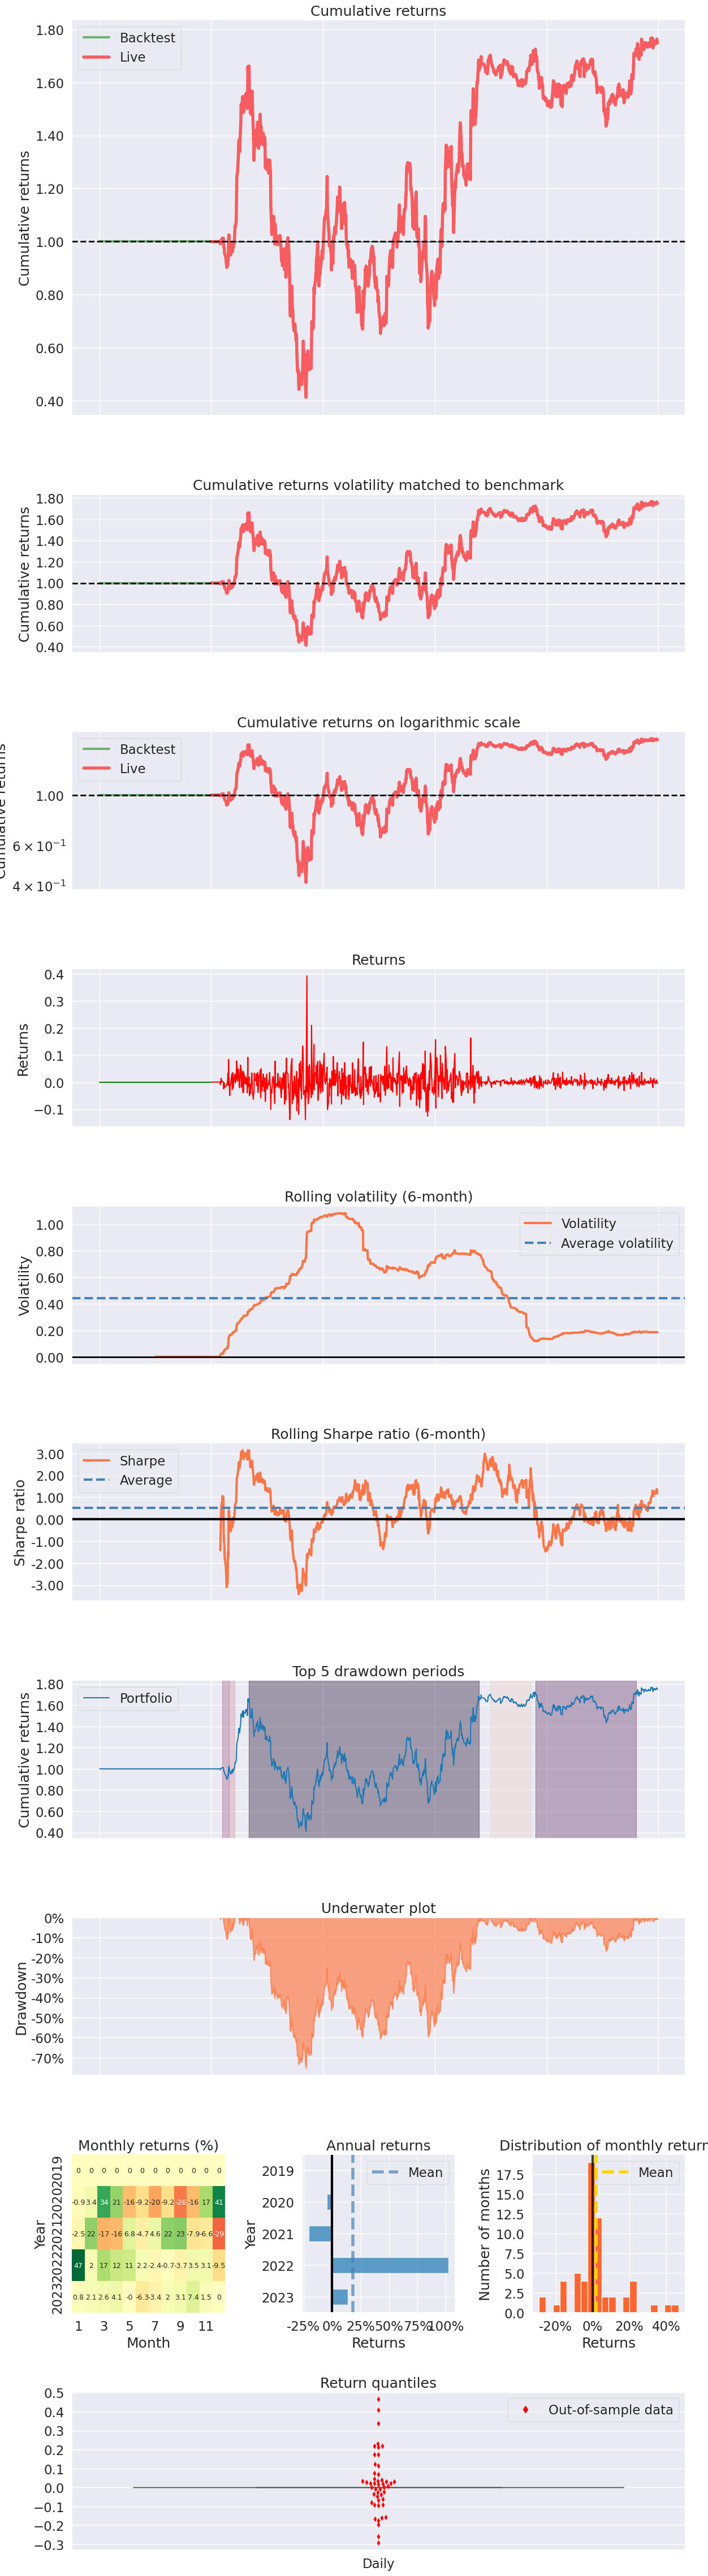

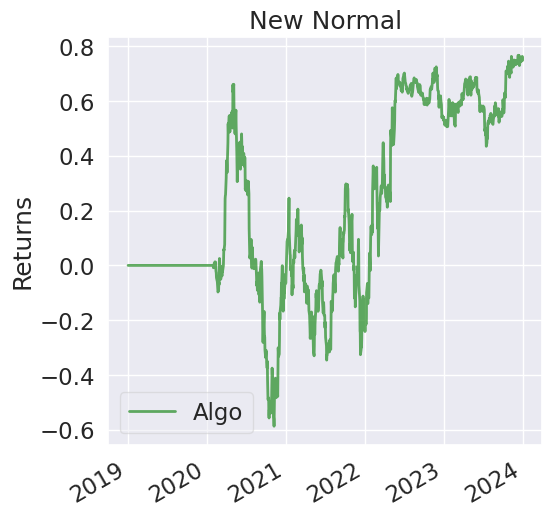

In [11]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Close'].index[obs])